/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


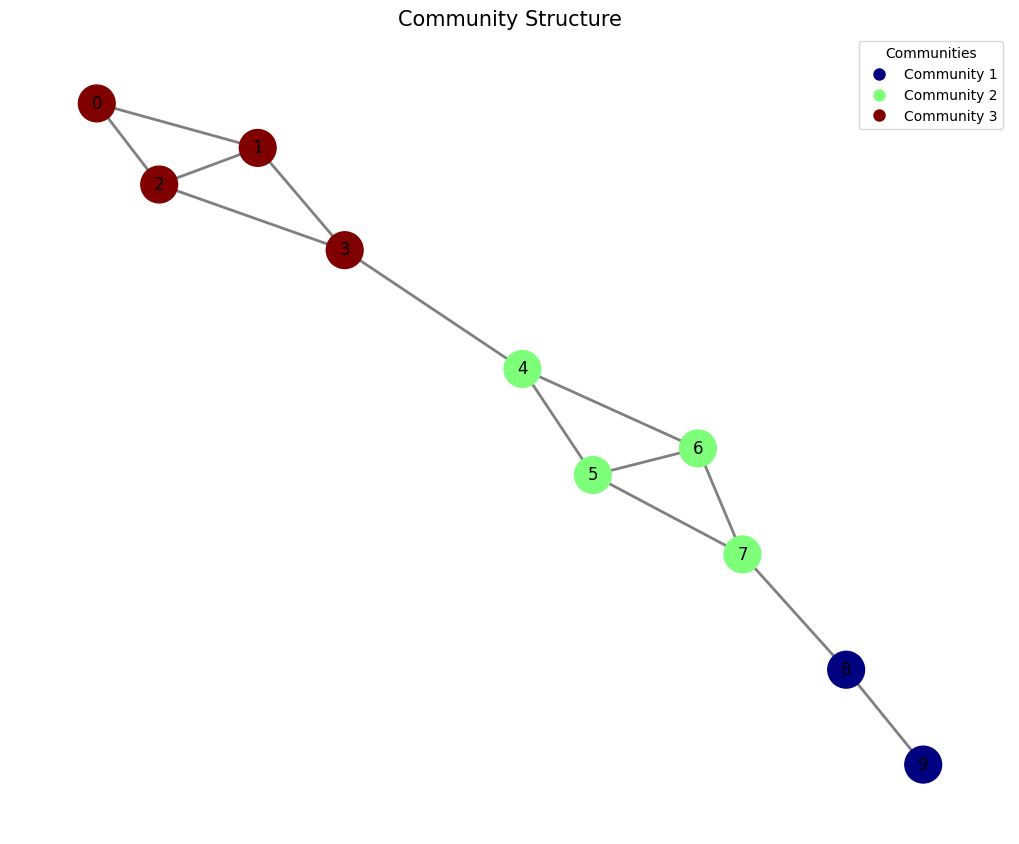

Community Matrix:
   Node  Community
0     0          3
1     1          3
2     2          3
3     3          3
4     4          2
5     5          2
6     6          2
7     7          2
8     8          1
9     9          1


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors

# Fuzzy Clustering Phase (Fine-Tuning)
def fuzzy_clustering_phase(data, c, m=2, max_iter=100, epsilon=1e-6):
    n = data.shape[0]
    U = np.random.rand(n, c)
    U = U / np.sum(U, axis=1, keepdims=True)
    for iteration in range(max_iter):
        # Compute the fuzzy centers
        U_m = U ** m
        centers = (U_m.T @ data) / np.sum(U_m, axis=0)[:, None]

        # Update membership matrix
        dist = np.linalg.norm(data[:, None] - centers, axis=2)  # Shape (n, c)
        dist[dist == 0] = 1e-10


        U_new = 1.0 / np.sum((dist[:, :, None] / dist[:, None, :]) ** (2 / (m - 1)), axis=2)
        U_new = U_new / np.sum(U_new, axis=1, keepdims=True)

        # Check for convergence
        if np.linalg.norm(U_new - U) < epsilon:
            break
        U = U_new

    return U, centers

def visualize_communities(community_structure, adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    unique_communities = np.unique(community_structure)
    community_colors = plt.cm.jet(np.linspace(0, 1, len(unique_communities)))

    color_map = {community: color for community, color in zip(unique_communities, community_colors)}
    colors = [color_map[community] for community in community_structure]

    pos = nx.spring_layout(G, seed=42, k=0.2, iterations=50)

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=700, cmap=plt.cm.jet, font_size=12, edge_color='gray', width=2)
    plt.title("Community Structure", size=15)

    community_labels = [f"Community {i}" for i in unique_communities]

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in community_colors]
    plt.legend(handles, community_labels, title="Communities", loc="best", fontsize=10)

    plt.show()
    community_matrix = pd.DataFrame({'Node': np.arange(len(community_structure)), 'Community': community_structure})
    print("Community Matrix:")
    print(community_matrix)

# Exploration Phase (Ant's movement on the graph)
def exploration_phase(adj_matrix, num_ants, alpha=1.0, beta=2.0, evaporation_rate=0.07, max_iterations=100):
    pheromone = np.ones_like(adj_matrix, dtype=float)  # Initializing pheromone matrix with all entries as 1
    ants = np.zeros(num_ants, dtype=int)  # Store the current vertex for each ant

    for i in range(num_ants):
        ants[i] = i  # Each ant starting at random position

    for iteration in range(max_iterations):
        for ant in range(num_ants):
            current_vertex = ants[ant]

            neighbors = np.where(adj_matrix[current_vertex] > 0)[0]
            if len(neighbors) == 0:
                continue  # Skip if no neighbors available
            # Calculating the probabilites
            pheromone_levels = pheromone[current_vertex, neighbors] ** alpha
            distances = adj_matrix[current_vertex, neighbors] ** (-beta)
            probabilities = pheromone_levels * distances
            probabilities /= probabilities.sum()

            # Choose the next vertex based on probabilities
            next_vertex = np.random.choice(neighbors, p=probabilities)
            ants[ant] = next_vertex  # Move the ant

            pheromone[current_vertex, next_vertex] += 1  # Increment pheromone on edge

        # Evaporate pheromones to avoid early convergence
        pheromone *= (1 - evaporation_rate)

    return pheromone
# Construction Phase
# Construct communities based on pheromone levels
def construction_phase(pheromone, adj_matrix):
    community_structure = np.zeros(adj_matrix.shape[0], dtype=int)
    community_id = 0  # Community identifier
    community_connections = {}

    # Sort edges by pheromone levels (descending order)
    edges = [(i, j) for i in range(adj_matrix.shape[0]) for j in range(i+1, adj_matrix.shape[0])]
    edges.sort(key=lambda x: pheromone[x[0], x[1]], reverse=True)

    for i, j in edges:
        if community_structure[i] == 0 and community_structure[j] == 0:
            # Both nodes are unassigned; create a new community
            community_structure[i] = community_structure[j] = community_id
            community_id += 1
        elif community_structure[i] == 0:
            # Node i is unassigned; add it to j's community
            community_structure[i] = community_structure[j]
        elif community_structure[j] == 0:
            # Node j is unassigned; add it to i's community
            community_structure[j] = community_structure[i]
        else:
            # Both nodes belong to different communities; create/strengthen connection
            comm1 = community_structure[i]
            comm2 = community_structure[j]
            if comm1 != comm2:
                if (comm1, comm2) not in community_connections:
                    community_connections[(comm1, comm2)] = pheromone[i, j]
                else:
                    community_connections[(comm1, comm2)] += pheromone[i, j]

    return community_structure, community_connections

# Local Optimization Phase
def optimization_phase(community_structure, adj_matrix):
    num_nodes = len(community_structure)
    internal_degree = np.zeros(num_nodes, dtype=int)
    external_degree = np.zeros(num_nodes, dtype=int)

    # Compute internal and external degrees for each node
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i, j] > 0:
                if np.equal(community_structure[i], community_structure[j]):
                    internal_degree[i] += 1
                else:
                    external_degree[i] += 1

    # Sort nodes by external degree in descending order
    sorted_nodes = np.argsort(-external_degree)

    # Reassign nodes to maximize community strength
    for node in sorted_nodes:
        current_community = community_structure[node]

        community_connections = {}
        for neighbor in range(num_nodes):
            if adj_matrix[node, neighbor] > 0:
                neighbor_community = community_structure[neighbor]
                if neighbor_community != current_community:
                    if neighbor_community not in community_connections:
                        community_connections[neighbor_community] = adj_matrix[node, neighbor]
                    else:
                        community_connections[neighbor_community] += adj_matrix[node, neighbor]

        # Find the community with the strongest external connection
        if community_connections:
            strongest_community = max(community_connections, key=community_connections.get)
            # Reassign node if the strongest community has more connections than the current internal degree
            if community_connections[strongest_community] > internal_degree[node]:
                community_structure[node] = strongest_community

    return community_structure

def community_detection():
    # Step 1: Get user input for adjacency matrix size and values
    n = int(input("Enter the number of nodes in the graph: "))
    adj_matrix = np.zeros((n, n), dtype=int)

    print("Enter the adjacency matrix row by row (each row's elements separated by spaces):")
    for i in range(n):
        row = list(map(int, input(f"Row {i + 1}: ").split()))
        adj_matrix[i] = row

    num_ants = adj_matrix.shape[0]  # Number of ants equals the number of vertices

    # Step 2: Exploration phase to generate pheromone matrix
    pheromone = exploration_phase(adj_matrix, num_ants)

    # Step 3: Construct initial community structure using pheromone matrix
    community_structure, community_connections = construction_phase(pheromone, adj_matrix)

    # Step 4: Optimize community structure to maximize modularity
    optimized_community_structure = optimization_phase(community_structure, adj_matrix)

    # Step 5: Convert optimized community structure into a plot and display
    visualize_communities(optimized_community_structure, adj_matrix)

community_detection()
